In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
table_measurement = pd.read_sql_table(table_name="measurement", con=engine)
len(table_measurement.sort_values(["id"]))

19550

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
days = (session.query(Measurement.date,Measurement.prcp)
             .filter(func.strftime("%Y-%m-%d", Measurement.date)> "2016-08-22").all()
            )
# Calculate the date 1 year ago from the last data point in the database
last_data_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data_date_dt = dt.datetime.strptime(last_data_date[0], '%Y-%m-%d')
one_year_ago = dt.date(last_data_date_dt.year -1, last_data_date_dt.month, last_data_date_dt.day)
print(f"The date 1 year ago from the last data point in the database is {one_year_ago}")
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitaion_last_1_year = pd.DataFrame(days)
precipitaion_last_1_year = (precipitaion_last_1_year.drop_duplicates(subset=['date'], keep='first'))
# Sort the dataframe by date
precipitaion_last_1_year = pd.DataFrame(days)
precipitaion_last_1_year = precipitaion_last_1_year.sort_values(by=['date'], ascending=True)
precipitaion_last_1_year = precipitaion_last_1_year.dropna(how='any')
length_of_data=(len(precipitaion_last_1_year.iloc[:,0]))
# Use Pandas Plotting with Matplotlib to plot the data
precipitaion_last_1_year.head()

The date 1 year ago from the last data point in the database is 2016-08-23


,date,prcp
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70


In [14]:
round(precipitaion_last_1_year.describe(),2)

,prcp
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [15]:
summary_df = pd.DataFrame({"Data Length": [length_of_data],
                              "One Year Back": one_year_ago,
                              "Latest Date": last_data_date[0]}
                         ).reset_index(drop=True)
summary_df

,Data Length,One Year Back,Latest Date
0,2021,2016-08-23,2017-08-23


In [16]:
Precipitation = precipitaion_last_1_year['prcp'].tolist()
Date = precipitaion_last_1_year['date'].tolist()

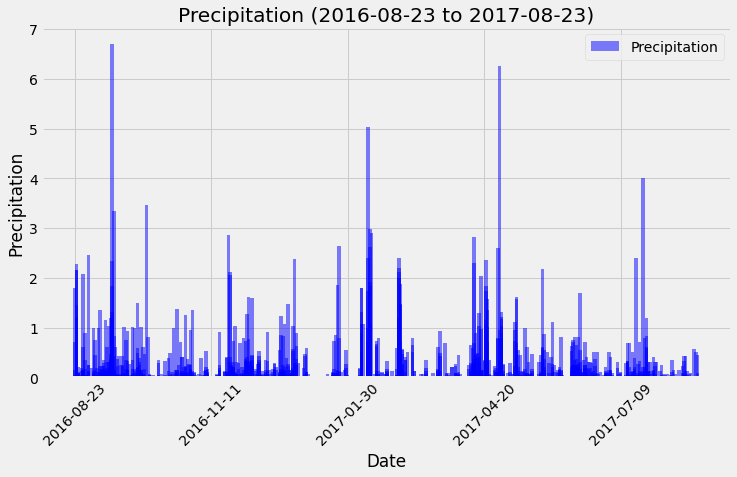

In [17]:
plt.figure(figsize=(11,6))
plt.bar(Date,Precipitation,width = 2 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(labelbottom=True)
plt.xticks(np.arange(0,400,80),rotation=45)

plt.title(f"Precipitation ({one_year_ago} to {last_data_date[0]})")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.id)).
                   group_by(Measurement.station).
                   order_by(func.count(Measurement.id).
                   desc())
                  ).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = (session.query(Measurement.station,
                                     func.max(Measurement.tobs), func.min(Measurement.tobs),
                                     func.avg(Measurement.tobs)
                                    ).
                       group_by(Measurement.station).
                       order_by(func.count(Measurement.id).
                                desc()).first()
                      )
most_active_station

('USC00519281', 85.0, 54.0, 71.66378066378067)

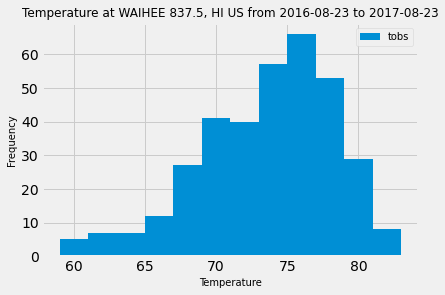

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = (session.query(Measurement.tobs).
                              filter(Measurement.station == active_stations[0][0]).
                              filter(Measurement.date >= one_year_ago).all()
                             )
temperatures = list(np.ravel(temp_query))
station_name = session.query(Station.name).filter(Station.station == "USC00519281").first()

plt.hist(temperatures, bins=12, rwidth=1,label='tobs')
plt.ylabel('Frequency',fontsize=10)
plt.xlabel('Temperature',fontsize=10)
plt.title(f"Temperature at {station_name[0]} from {one_year_ago} to {last_data_date[0]}",fontsize=12)
plt.legend(fontsize=10)

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
